In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Overview

In [ ]:
!pip3 install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 4.2 MB/s eta 0:00:00


## Importing Libraries and Reading the Dataset

In [ ]:
import zipfile
import patoolib
import seaborn as sns

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
def unrar_file(rar_path, extract_path):
    patoolib.extract_archive(rar_path, outdir=extract_path)

In [ ]:
# Đường dẫn và tên tệp tin ZIP, https://drive.google.com/drive/u/0/folders/138lKzP8x-9167RX7dY71JMIRXjkwL9it
zip_path = '/content/drive/MyDrive/GGColab/Image/Image.rar'

extract_path = '/content/'

unrar_file(zip_path, extract_path)


PatoolError: file `/content/drive/MyDrive/GGColab/Image/Image.rar' was not found

In [ ]:
import os
leafs = ['Cachua', 'Diepca', 'Dinhlang', 'LaMe', 'LaOi', 'Labang', 'Lachanh', 'Vusua', 'Lakhe', 'Mongtoi']
statuss = ['healthy', 'unhealthy']
folders = ['train','val','test']

data_train = {}
data_val = {}
data_test = {}

def get_num_pic(path,data):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        folder_name = os.path.basename(root)
        file_count = len(files)
        data[folder_name] = file_count

In [ ]:
get_num_pic("/content/Image/Image/train",data_train)
get_num_pic("/content/Image/Image/val",data_val)
get_num_pic("/content/Image/Image/test",data_test)

# vẽ biểu đồ plot cho dữ liệu
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(data_test.keys(), data_test.values())
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.set_title('Number of images in each class in test set')
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(data_test.keys(), data_train.values())
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.set_title('Number of images in each class in train set')
plt.xticks(rotation=90)
plt.show()


fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(data_test.keys(), data_val.values())
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.set_title('Number of images in each class in val set')
plt.xticks(rotation=90)
plt.show()

In [ ]:
list = []
for (train, val, test) in zip(data_train.values(), data_val.values(), data_test.values()):
  list.append (train + val + test)


fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(data_test.keys(), list)
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.set_title('Number of images in each class')
plt.xticks(rotation=90)
plt.show()

In [ ]:
import pandas as pd
import os

def getData(root_path, type_folder):
    type_leaf = []
    status = []
    filenames =[]

    for leaf in leafs:
      for st in statuss:
        path = root_path + '/' + type_folder + '/' + leaf + '_' + st

        image_files = os.listdir(path)
        for image_file in image_files:
          filenames.append(os.path.join(path, image_file))
          type_leaf.append(leafs.index(leaf))
          status.append(1 if st == 'healthy' else 0)

    return pd.DataFrame({
                        'filename' : filenames,
                        'type_leaf': type_leaf,
                        'status': status
                        })

In [ ]:
leaf_train = getData('/content/Image/Image','train')
leaf_val = getData('/content/Image/Image','val')
leaf_test = getData('/content/Image/Image','test')

In [ ]:
from keras.utils import to_categorical
onehot_leaf_train = to_categorical(leaf_train['type_leaf'].values)
onehot_leaf_val = to_categorical(leaf_val['type_leaf'].values)
onehot_leaf_test = to_categorical(leaf_test['type_leaf'].values)

leaf_train['onehot_leaf'] = onehot_leaf_train.tolist()
leaf_val['onehot_leaf'] = onehot_leaf_val.tolist()
leaf_test['onehot_leaf'] = onehot_leaf_test.tolist()

In [ ]:
leaf_train.head()

In [ ]:
leaf_val.head()

NameError: name 'leaf_val' is not defined

In [ ]:
leaf_test.head()

NameError: name 'leaf_test' is not defined

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=45,
    rescale = 1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

test_gen = ImageDataGenerator(
    rescale = 1.0/255,
)


In [ ]:
leafs_train_gen = train_gen.flow_from_dataframe(
    leaf_train,
    shuffle=True,
    y_col=['status', 'onehot_leaf'],
    class_mode='multi_output',
    target_size=(224, 224),
    batch_size=64,
)

Found 4316 validated image filenames.


In [ ]:
leafs_val_gen = test_gen.flow_from_dataframe(
    leaf_val,
    shuffle=True,
    y_col=['status', 'onehot_leaf'],
    class_mode='multi_output',
    target_size=(224, 224),
    batch_size=64,
)

Found 675 validated image filenames.


In [ ]:
leafs_test_gen = test_gen.flow_from_dataframe(
    leaf_test,
    shuffle=False,
    y_col=['status', 'onehot_leaf'],
    class_mode='multi_output',
    target_size=(224, 224),
    batch_size=1,
)

Found 876 validated image filenames.


## Model


In [ ]:
from keras import applications

INPUT_SHAPE = (224, 224, 3)

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False
# for layer in base_model.layers:
#     if layer.name.startswith('block5'):
#       layer.trainable = True
#     else:
#       layer.trainable = False

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
base_model.summary(show_trainable=True)

Model: "vgg16"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, GlobalMaxPooling2D, Flatten, Dropout
from keras import regularizers
from tensorflow.keras import Model

x = Flatten()(last_output)


status_prediction = Dense(256, kernel_regularizer=regularizers.l2(0.01),activation="relu")(x)
status_prediction = Dropout(0.2)(status_prediction)
status_prediction = Dense(1, activation='sigmoid', name="status_output")(status_prediction)


leaf_prediction = Dense(512, kernel_regularizer=regularizers.l2(0.01),activation="relu")(x)
leaf_prediction = Dropout(0.2)(leaf_prediction)
leaf_prediction = Dense(10)(leaf_prediction)
leaf_prediction = Activation('softmax', name="leaf_output")(leaf_prediction)


model = Model(inputs=base_model.input, outputs=[status_prediction, leaf_prediction])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

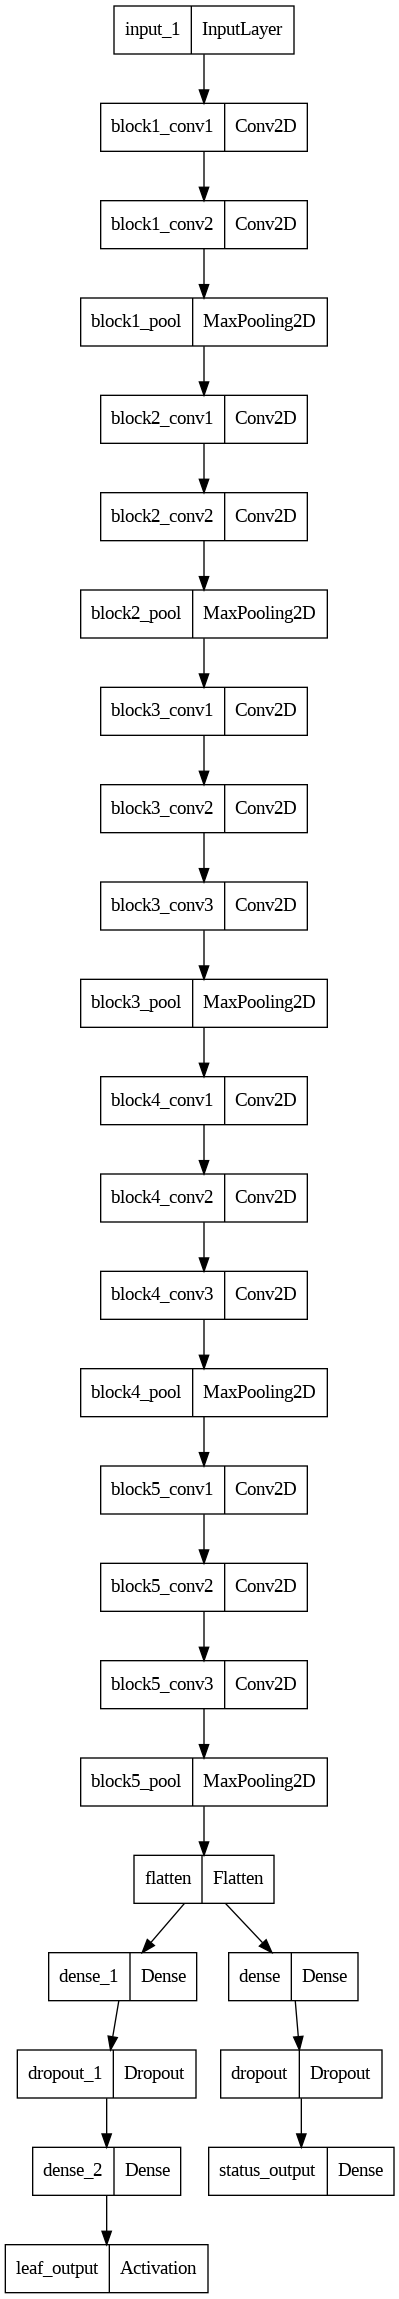

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model)

Train Model


In [ ]:
losses = {
	"status_output": "binary_crossentropy",
	"leaf_output": "categorical_crossentropy",
}

lossWeights = {"status_output": 1.0, "leaf_output": 1.0}
model.compile(loss=losses, loss_weights=lossWeights, optimizer='Adam', metrics=['accuracy'])

## Training

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import csv
from tensorflow.keras.callbacks import Callback
class LossHistory(Callback):
    def __init__(self, filename='/content/drive/MyDrive/GGColab/Image/LeafCls/log.csv', separator=','):
        self.filename = filename
        self.separator = separator
        self.losses = []
        self.val_losses = []
        self.metrics = ['loss', 'status_output_loss', 'leaf_output_loss', 'status_output_accuracy',
                        'leaf_output_accuracy', 'val_loss', 'val_status_output_loss', 'val_leaf_output_loss',
                        'val_status_output_accuracy', 'val_leaf_output_accuracy']

    def on_epoch_end(self, epoch, logs=None):
        epoch_data = [epoch] + [logs.get(metric) for metric in self.metrics]
        with open(self.filename, 'a') as f:
            writer = csv.writer(f, delimiter=self.separator)
            writer.writerow(epoch_data)

rlronp=ReduceLROnPlateau(monitor="val_loss",
                                            factor=0.1,
                                            mode = "auto",
                                            min_lr=1e-6,
                                            patience=3,
                                            verbose=0)

estop=EarlyStopping(monitor="val_loss",
                                       mode= "auto",
                                       patience=6,
                                       verbose=0,
                                       restore_best_weights=True)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/GGColab/Image/LeafCls/weights.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

# '/content/drive/MyDrive/GGColab/Image/LeafCls/weights.keras' là đường dẫn tới nơi lưu trọng số của mô hình. Trong ví dụ này, trọng số sẽ được lưu vào tệp có tên 'weights.keras' trong thư mục '/content/drive/MyDrive/GGColab/Image/LeafCls/'.
# monitor='val_loss' chỉ định đại lượng cần theo dõi để quyết định liệu có lưu trọng số tốt nhất hay không. Trong trường hợp này, đại lượng được theo dõi là 'val_loss', tức là giá trị hàm mất mát trên tập kiểm tra (validation set).
# verbose=0 xác định cách thông báo sẽ được hiển thị trong quá trình lưu trọng số. Trong trường hợp này, không có thông báo nào sẽ được hiển thị.
# save_best_only=True chỉ định liệu chỉ lưu trọng số của mô hình khi nó có hiệu suất tốt hơn so với các lần lưu trước đó hay không.
# save_weights_only=True chỉ định liệu chỉ lưu trọng số của mô hình hay lưu toàn bộ mô hình (bao gồm kiến trúc). Trong trường hợp này, chỉ lưu trọng số.
# mode='auto' chỉ định cách xác định hiệu suất tốt nhất. "auto" sẽ tự động xác định dựa trên giá trị của đại lượng được theo dõi (trong trường hợp này là 'val_loss').
# save_freq='epoch' chỉ định tần suất lưu trọng số. Trong trường hợp này, trọng số được lưu sau mỗi epoch (vòng lặp huấn luyện).
# initial_value_threshold=None được sử dụng để xác định ngưỡng ban đầu của đại lượng được theo dõi để quyết định liệu trọng số hiện tại có được lưu trữ hay không. Trong trường hợp này, không có ngưỡng ban đầu được xác định.

In [ ]:
train_steps = leafs_train_gen.n // 64
val_steps = leafs_val_gen.n // 64

history = model.fit(
    leafs_train_gen,
    epochs=60,
    steps_per_epoch=train_steps,
    validation_data=leafs_val_gen,
    verbose=1,
    callbacks=[estop, rlronp, checkpoint, LossHistory()]
)


Epoch 1/60
58/58 [==============================] - ETA: 0s - loss: 8.6001 - status_output_loss: 1.1669 - leaf_output_loss: 2.0702 - status_output_accuracy: 0.6415 - leaf_output_accuracy: 0.6456
Epoch 1: val_loss improved from inf to 3.30339, saving model to /content/drive/MyDrive/GGColab/Image/LeafCls/weights.keras
58/58 [==============================] - 198s 3s/step - loss: 8.6001 - status_output_loss: 1.1669 - leaf_output_loss: 2.0702 - status_output_accuracy: 0.6415 - leaf_output_accuracy: 0.6456 - val_loss: 3.3034 - val_status_output_loss: 0.4127 - val_leaf_output_loss: 0.4865 - val_status_output_accuracy: 0.8465 - val_leaf_output_accuracy: 0.8569 - lr: 0.0010
Epoch 2/60
58/58 [==============================] - ETA: 0s - loss: 2.3465 - status_output_loss: 0.3894 - leaf_output_loss: 0.3373 - status_output_accuracy: 0.8402 - leaf_output_accuracy: 0.9005
Epoch 2: val_loss improved from 3.30339 to 1.90749, saving model to /content/drive/MyDrive/GGColab/Image/LeafCls/weights.keras
58/

## Evaluate

In [ ]:
model.load_weights('/content/drive/MyDrive/GGColab/Image/LeafCls/weights.keras')

In [ ]:
model.evaluate(leafs_test_gen, steps=len(leafs_test_gen))

876/876 [==============================] - 594s 676ms/step - loss: 2.7856 - status_output_loss: 0.3688 - leaf_output_loss: 2.1924 - status_output_accuracy: 0.8311 - leaf_output_accuracy: 0.6256


[2.785555362701416,
 0.36876004934310913,
 2.1924171447753906,
 0.8310502171516418,
 0.6255707740783691]

Text(0, 0.5, 'loss')

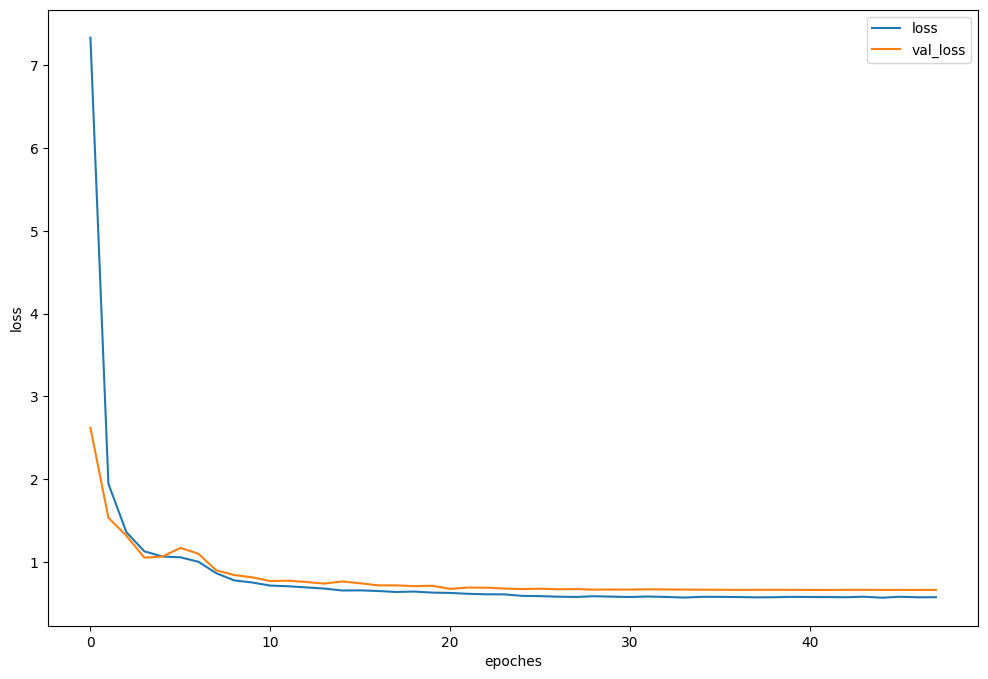

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(history.history['loss'], label="loss")
sns.lineplot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.xlabel("epoches")
plt.ylabel("loss")

Text(0, 0.5, 'loss')

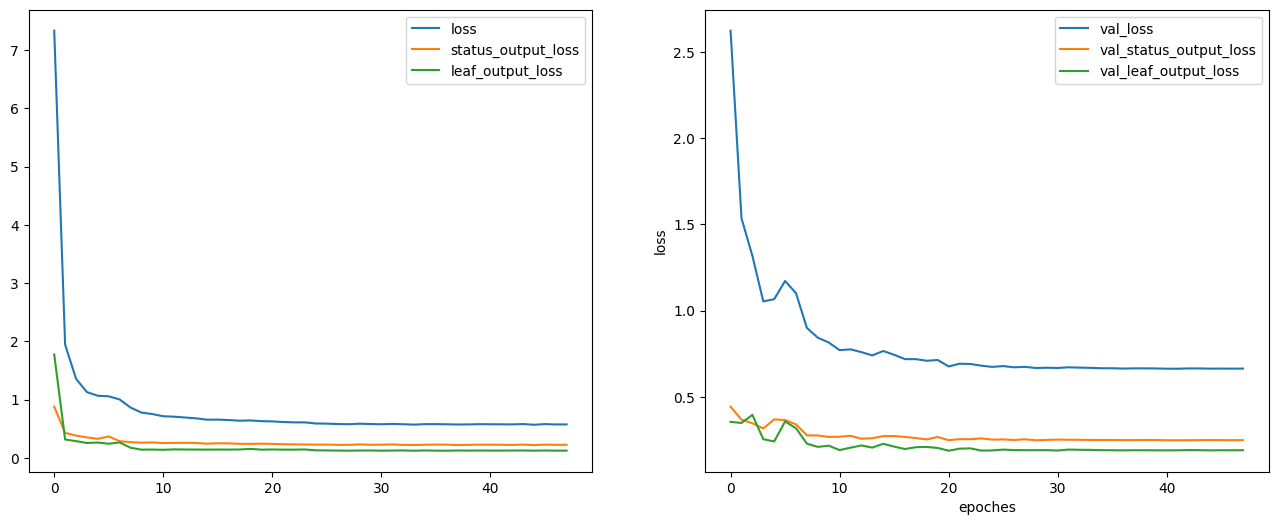

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


sns.lineplot(history.history['loss'], label="loss", ax=ax1)
sns.lineplot(history.history['status_output_loss'], label="status_output_loss", ax=ax1)
sns.lineplot(history.history['leaf_output_loss'], label="leaf_output_loss", ax=ax1)
plt.legend()

sns.lineplot(history.history['val_loss'], label="val_loss", ax=ax2)
sns.lineplot(history.history['val_status_output_loss'], label="val_status_output_loss", ax=ax2)
sns.lineplot(history.history['val_leaf_output_loss'], label="val_leaf_output_loss", ax=ax2)
plt.legend()

plt.subplots_adjust(hspace=0.3)
plt.xlabel("epoches")
plt.ylabel("loss")

Text(0.5, 0, 'epoches')

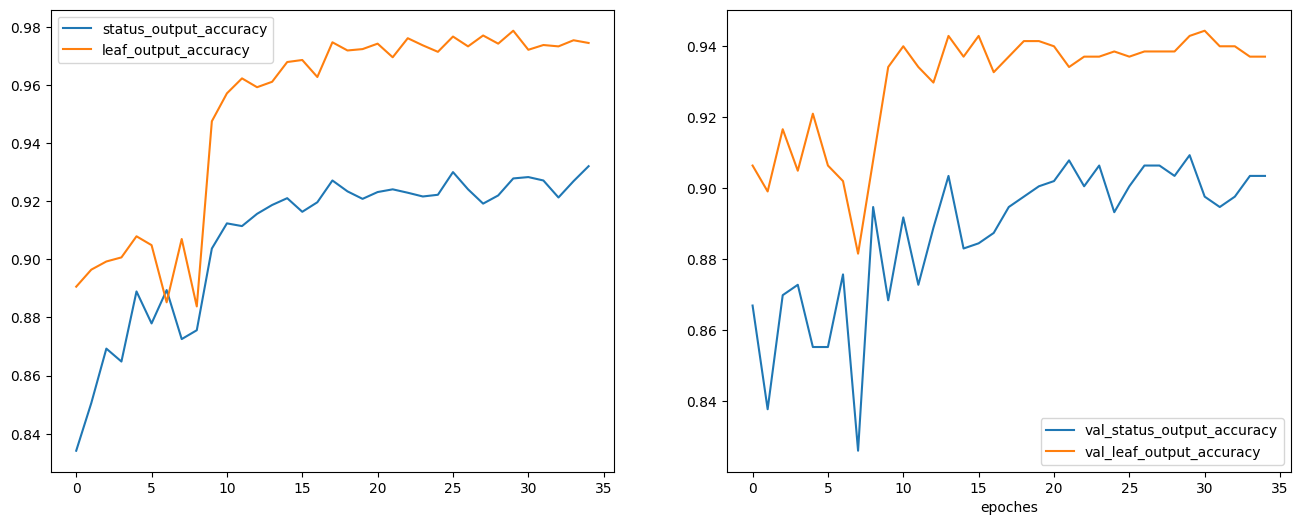

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


sns.lineplot(history.history['status_output_accuracy'], label="status_output_accuracy", ax=ax1)
sns.lineplot(history.history['leaf_output_accuracy'], label="leaf_output_accuracy", ax=ax1)
plt.legend()

sns.lineplot(history.history['val_status_output_accuracy'], label="val_status_output_accuracy", ax=ax2)
sns.lineplot(history.history['val_leaf_output_accuracy'], label="val_leaf_output_accuracy", ax=ax2)
plt.legend()

plt.subplots_adjust(hspace=0.3)
plt.xlabel("epoches")

1/1 [==============================] - 1s 945ms/step
                    Cachua_healthy  Cachua_unhealthy  Diepca_healthy  \
Cachua_healthy                  24                 6               1   
Cachua_unhealthy                 5                27               0   
Diepca_healthy                   2                 0              25   
Diepca_unhealthy                 0                 0               4   
Dinhlang_healthy                 0                 0               0   
Dinhlang_unhealthy               0                 0               0   
LaMe_healthy                     1                 0               0   
LaMe_unhealthy                   0                 0               0   
LaOi_healthy                     0                 0               0   
LaOi_unhealthy                   0                 0               0   
Labang_healthy                   0                 0               0   
Labang_unhealthy                 0                 0               0   
Lachanh_hea

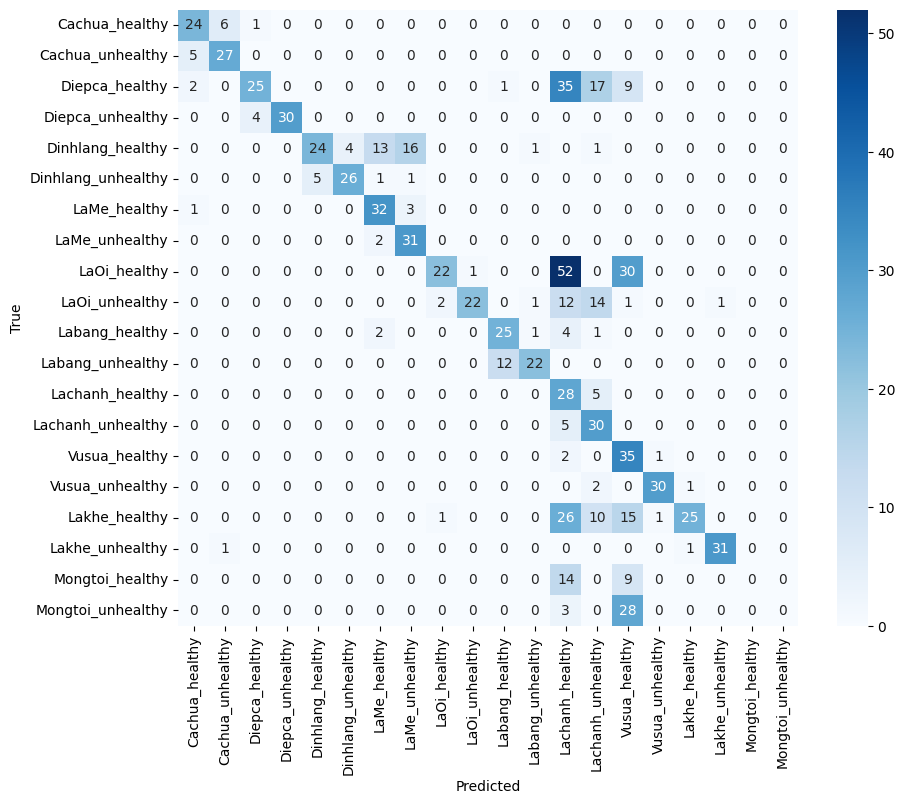

In [ ]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from PIL import Image
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from keras import applications
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, GlobalMaxPooling2D, Flatten, Dropout
from tensorflow.keras import Model

leafs = ['Cachua', 'Diepca', 'Dinhlang', 'LaMe', 'LaOi', 'Labang', 'Lachanh', 'Vusua', 'Lakhe', 'Mongtoi']
class_names = ['Cachua_healthy', 'Cachua_unhealthy', 'Diepca_healthy', 'Diepca_unhealthy', 'Dinhlang_healthy', 'Dinhlang_unhealthy', 'LaMe_healthy', 'LaMe_unhealthy', 'LaOi_healthy', 'LaOi_unhealthy', 'Labang_healthy', 'Labang_unhealthy', 'Lachanh_healthy', 'Lachanh_unhealthy', 'Vusua_healthy', 'Vusua_unhealthy', 'Lakhe_healthy', 'Lakhe_unhealthy', 'Mongtoi_healthy', 'Mongtoi_unhealthy']
statuss = ['healthy', 'unhealthy']
folders = ['train','val','test']

#duyệt qua từng folder trong thư mục test
y_true = []
y_pred = []
for leaf in leafs:
    for st in statuss:
      path = "Image/Image" + '/' + 'test' + '/' + leaf + '_' + st
      image_files = os.listdir(path)
      for image_file in image_files:
            image_path = os.path.join(path, image_file)
            image = Image.open(image_path)
            image = image.resize((224, 224))

            # Chuyển đổi ảnh thành mảng numpy
            image_array = np.array(image) / 255.0  # Chuẩn hóa giá trị pixel

            # Thêm một chiều cho batch (vì model cần input dưới dạng batch)
            image_array = np.expand_dims(image_array, axis=0)
            # Dự đoán lớp của ảnh
            predictions = model.predict(image_array)
            type_leafs = np.argmax(predictions[1])
            type_status = 'unhealthy' if predictions[0][0] <= 0.5 else 'healthy'
            y_true.append(leaf + '_' + st)
            y_pred.append(leafs[type_leafs] + '_' + type_status)

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
print(df_cm)

# vẽ ma trận nhầm lẫn dưới dạng heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()






